In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experimeny reproducability
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

**Import the Speech Commands dataset**

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
    extract=True,
    cache_dir='.', cache_subdir='data')

In [12]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'yes']


Extract the audio files into a list and shuffle it.

In [13]:
filenames = tf.io.gfile.glob(str(data_dir)+ '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of totale examples:', num_samples)
print('Number of examples per label:', 
     len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of totale examples: 2002
Number of examples per label: 1001
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\no\\c38720cb_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [15]:
train_files = filenames[:1600]
val_files = filenames[1600 : 1600+202]
test_files = filenames[-200:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1600
Validation set size 202
Test set size 200


**Reading audio files and their labels**

In [6]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [7]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    # We'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    print('Path in form of list:', parts)
    return parts[-2]

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [8]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

You will now apply process_path to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls = AUTOTUNE)

Path in form of list: Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


Let's examine a few audio waveforms with their corresponding labels.

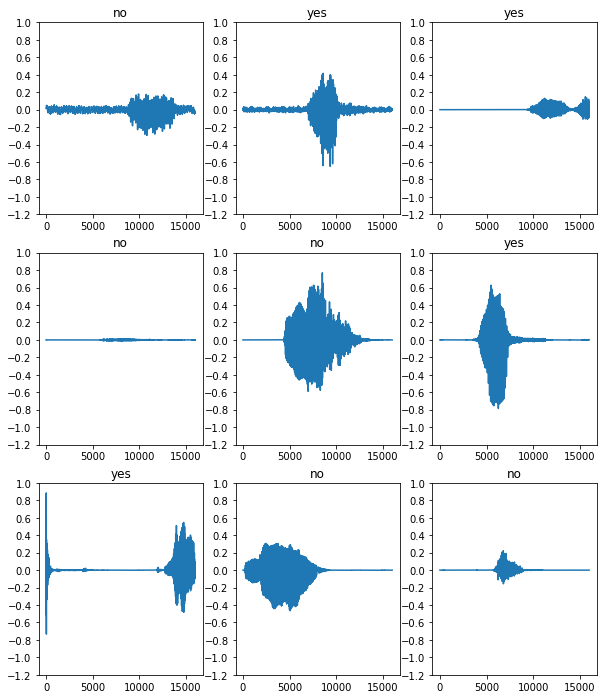

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10,12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i%cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

**Spectrogram**

In [19]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length = 255, frame_step = 128)
    
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.


In [25]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio Playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio Playback


<ipython-input-27-c8e05f107ef1>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


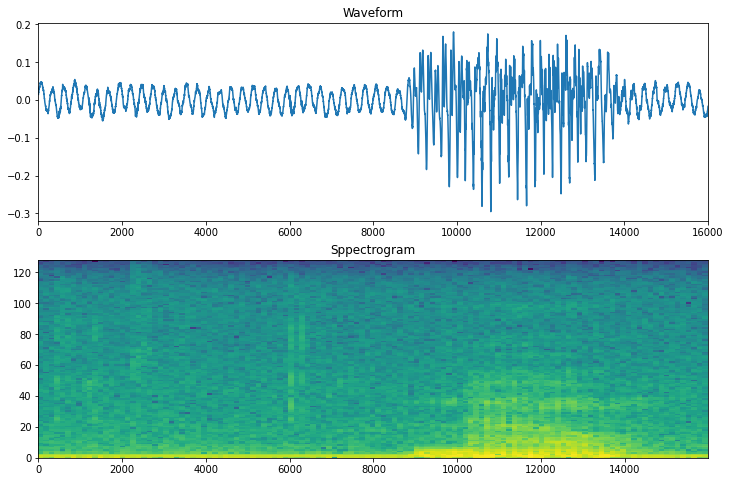

In [27]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(16000, step = height+1)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    

fig, axes = plt.subplots(2, figsize = (12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Sppectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [28]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [29]:
spectrogram_ds = waveform_ds.map(
        get_spectrogram_and_label_id, num_parallel_calls = AUTOTUNE)